In [8]:
import pandas as pd
import numpy as np

df = pd.read_csv('/root/jupyter_home/tank_project/ready/포탑제어 파트/Data/data_060211.csv')
df['dist'] = ((df['x_pos'] - df['x_target'])**2 + (df['y_pos'] - df['y_target'])**2 + (df['z_pos'] - df['z_target'])**2)**0.5
angle = np.array(df['y_angle'])
dist = np.array(df['dist'])

def find_angle_for_distance(target_distance, angles, distances):
    """
    주어진 목표 거리(target_distance)에 대응하는 발사 각도를
    선형 보간법으로 계산합니다.
    1. distances 배열을 오름차순으로 정렬하면서 대응되는 angles도 함께 재정렬
    2. np.interp를 사용해 보간(interpolation)한 값을 반환
    """
    # (1) 거리 기준으로 정렬
    sort_idx = np.argsort(distances)
    sorted_distances = distances[sort_idx]
    sorted_angles = angles[sort_idx]
    
    # (2) 목표 거리가 측정 범위 안에 있는지 체크
    if not (sorted_distances.min() <= target_distance <= sorted_distances.max()):
        raise ValueError(f"목표 거리 {target_distance}m 은(는) 측정된 거리 범위를 벗어납니다.")
    
    
    # (3) 선형 보간
    required_angle = np.interp(target_distance, sorted_distances, sorted_angles)
    return required_angle

# ── 사용 예시 ──
# 내 탱크 좌표 (x0, y0)와 목표 좌표 (xt, yt)가 있다고 가정
x, z = map(float, input().split())
x0, y0, z0 = (x, 8.0, z)
xt, yt, zt = (135.4600, 8.6, 276.8700)
# 2D 유클리디언 거리 계산
target_distance = np.sqrt((xt - x0)**2 + (yt - y0)**2 + (zt - z0)**2)

angle_to_fire = find_angle_for_distance(target_distance, angle, dist)
print(f"목표 거리 {target_distance:.2f}m 에 도달하려면 약 {angle_to_fire:.2f}° 로 쏘세요.")

목표 거리 31.01m 에 도달하려면 약 -1.82° 로 쏘세요.


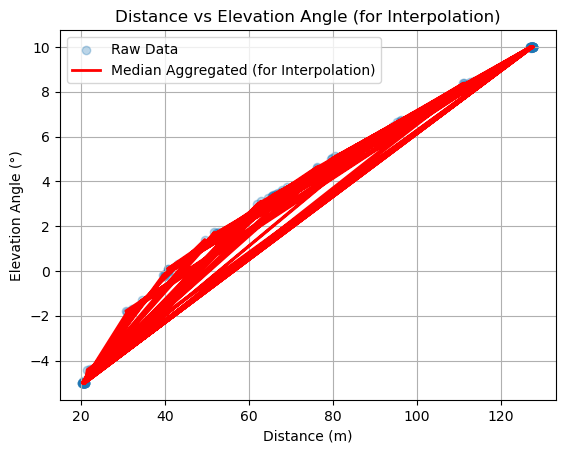

In [9]:
import matplotlib.pyplot as plt

plt.scatter(df['dist'], df['y_angle'], alpha=0.3, label='Raw Data')
plt.plot(dist, angle, color='red', label='Median Aggregated (for Interpolation)', linewidth=2)
plt.xlabel("Distance (m)")
plt.ylabel("Elevation Angle (°)")
plt.title("Distance vs Elevation Angle (for Interpolation)")
plt.legend()
plt.grid(True)
plt.show()


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# CSV 파일 로드
df = pd.read_csv('/root/jupyter_home/tank_project/ready/포탑제어 파트/Data/data_060211.csv')

# 거리 계산
df['dist'] = np.sqrt(
    (df['x_pos'] - df['x_target'])**2 +
    (df['y_pos'] - df['y_target'])**2 +
    (df['z_pos'] - df['z_target'])**2
)

# ✅ 130m 넘는 거리 제거 (이상치)
df = df[df['dist'] <= 130]

# ✅ 21m보다 가까운 거리 제거 (이상치)
df = df[df['dist'] > 21]

# ✅ 각 y_angle별 중앙값 거리 계산
grouped = df.groupby('y_angle')['dist'].median().reset_index()

# 보간용 배열 생성
angles = np.array(grouped['y_angle'])        # y축 각도
distances = np.array(grouped['dist'])        # 중앙값 거리

def find_angle_for_distance(target_distance, angles, distances):
    # 거리 기준 정렬
    sort_idx = np.argsort(distances)
    sorted_distances = distances[sort_idx]
    sorted_angles = angles[sort_idx]
    
    # 범위 확인
    if not (sorted_distances.min() <= target_distance <= sorted_distances.max()):
        raise ValueError(f"Target distance {target_distance:.2f}m is out of interpolation range.")
    
    # 선형 보간
    return np.interp(target_distance, sorted_distances, sorted_angles)

# ── 사용 예시 ──
x, z = map(float, input("Enter your tank X Z position: ").split())
x0, y0, z0 = (x, 8.0, z)
xt, yt, zt = (135.4600, 8.6, 276.8700)
target_distance = np.sqrt((xt - x0)**2 + (yt - y0)**2 + (zt - z0)**2)

angle_to_fire = find_angle_for_distance(target_distance, angles, distances)
print(f"🎯 Target distance {target_distance:.2f}m → Required elevation angle: {angle_to_fire:.2f}°")

🎯 Target distance 31.01m → Required elevation angle: -1.82°


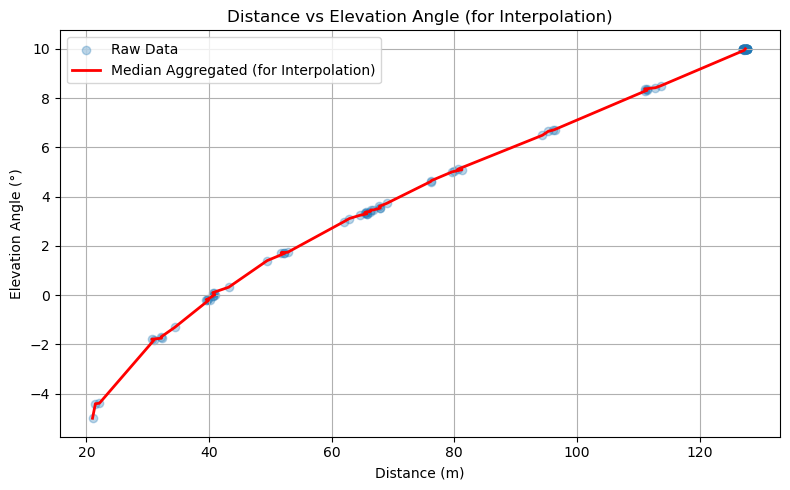

In [11]:
# ── 시각화 ──
plt.figure(figsize=(8, 5))
plt.scatter(df['dist'], df['y_angle'], alpha=0.3, label='Raw Data')
plt.plot(distances, angles, color='red', label='Median Aggregated (for Interpolation)', linewidth=2)
plt.xlabel("Distance (m)")
plt.ylabel("Elevation Angle (°)")
plt.title("Distance vs Elevation Angle (for Interpolation)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import math

def get_yaw_angle(player_pos, enemy_pos):
    dx = enemy_pos['x'] - player_pos['x']
    dz = enemy_pos['z'] - player_pos['z']

    # atan2는 radian 기준, z를 먼저 넣는 이유는 좌표계 때문
    angle_rad = math.atan2(dx, dz)
    angle_deg = math.degrees(angle_rad)

    # 0~359로 변환
    angle_deg = (angle_deg + 360) % 360

    return round(angle_deg, 2)

player_pos = {'x': 183.7831, 'z' : 250.0369}
enemy_pos = {'x' : 135.4600, 'z' : 276.8700}

print(get_yaw_angle(player_pos, enemy_pos))

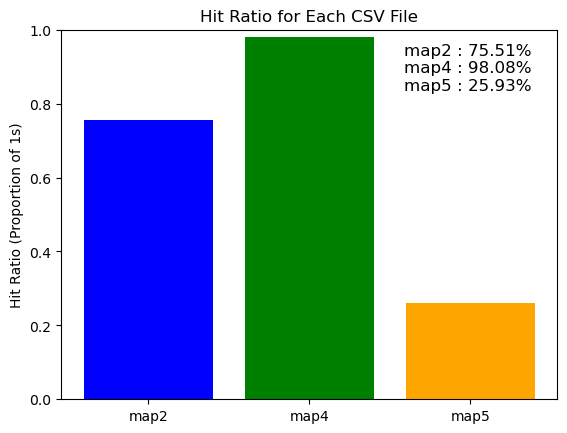

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

files = ['true_hit_ratio_map2.csv', 'true_hit_ratio_map4.csv', 'true_hit_ratio_map5.csv']

hit_ratios = []
labels = []

for file in files:
    df = pd.read_csv(file)
    ratio = df['is_hit'].mean()
    hit_ratios.append(ratio)
    labels.append(file.replace('true_hit_ratio_', '').replace('.csv', ''))

plt.bar(labels, hit_ratios, color=['blue', 'green', 'orange'])
plt.ylabel('Hit Ratio (Proportion of 1s)')
plt.title('Hit Ratio for Each CSV File')
plt.ylim(0, 1)

# 그래프 오른쪽에 텍스트로 퍼센트 표시
percent_text = "\n".join([f"{label} : {ratio*100:.2f}%" for label, ratio in zip(labels, hit_ratios)])
plt.gcf().text(0.66, 0.8, percent_text, fontsize=12, va='center')

plt.show()